# Explore the dataset


In this notebook, we will perform an EDA (Exploratory Data Analysis) on the processed Waymo dataset (data in the `processed` folder). In the first part, you will create a function to display 

In [1]:
#from utils import get_dataset
import glob
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import tensorflow as tf

import IPython.display as display
import random
import numpy as np

import matplotlib.patches as patches

import seaborn as sns
sns.set()

import glob
import os

%matplotlib inline

In [ ]:
#dataset = get_dataset("/home/workspace/data/waymo/training_and_validation/*.tfrecord") Original code

dataset = get_dataset("/home/workspace/data/train/*.tfrecord")

#I didn't use this as I couldn't find the right documentation for this data structure early on. Therefore,
# I parsed the image data manually here.

In [ ]:
type(dataset)

In [2]:
train_dir_path = os.path.join(os.getcwd(), "data", "train", "*.tfrecord")
all_tfr = glob.glob(train_dir_path)
all_tfr[0]

'/home/workspace/data/train/segment-1005081002024129653_5313_150_5333_150_with_camera_labels.tfrecord'

## Write a function to display an image and the bounding boxes

Implement the `display_images` function below. This function takes a batch as an input and display an image with its corresponding bounding boxes. The only requirement is that the classes should be color coded (eg, vehicles in red, pedestrians in blue, cyclist in green).

In [3]:
def decode_fn(record_bytes):
    """Parses the input tf.train.Example proto using the appropriate dictionary.
    """
    return tf.io.parse_single_example(
    record_bytes,
        {
        'image/object/bbox/xmin': tf.io.VarLenFeature(dtype = tf.float32),
        'image/object/bbox/xmax': tf.io.VarLenFeature(dtype = tf.float32),
        'image/object/bbox/ymin': tf.io.VarLenFeature(dtype = tf.float32),
        'image/object/bbox/ymax': tf.io.VarLenFeature(dtype = tf.float32),
        'image/object/class/label': tf.io.VarLenFeature(dtype = tf.int64),
        'image/object/class/text': tf.io.VarLenFeature(dtype = tf.string),
        'image/width': tf.io.FixedLenFeature([], tf.int64),
        'image/height': tf.io.FixedLenFeature([], dtype = tf.int64),
        'image/source_id': tf.io.FixedLenFeature([], dtype = tf.string),
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/format': tf.io.FixedLenFeature([], dtype=tf.string),
        'image/filename': tf.io.FixedLenFeature([], dtype=tf.string) 
        }  
    )

In [4]:
def decode_image(image_data):
    """Decodes image bytes.
    
    Args:
    -----
        image_data: bytes
            image byte string
            
    Returns:
    --------
        image: tensorflow.python.framework.ops.EagerTensor
    """
    
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32)/255.0
    return image

def gen_tfrecord_data(data_dict):
    """Generate one image dataset from a dictionary.
    
    Args:
    -----
        data_dict: dict
            tfrecord dict 
    
    Returns:
    --------
        (decoded_image, bboxes, size): tuple
            decoded_image: tensorflow.python.framework.ops.EagerTensor
                decoded image for plotting
            bboxes: list of tuples 
                form of tuples- (label, xmin, xmax, ymin, ymax)
                    Contains information about all the bounding boxes and their labels.
    """
    
    label_arr = data_dict["image/object/class/label"].values.numpy()
    xmin_arr = data_dict["image/object/bbox/xmin"].values.numpy()
    xmax_arr = data_dict["image/object/bbox/xmax"].values.numpy()
    ymin_arr = data_dict["image/object/bbox/ymin"].values.numpy()
    ymax_arr = data_dict["image/object/bbox/ymax"].values.numpy()
    
    size = np.hstack((data_dict["image/width"].numpy(),
            data_dict["image/height"].numpy()))
    
    xmin_arr = xmin_arr*size[0]
    xmax_arr = xmax_arr*size[0]
    ymin_arr = ymin_arr*size[1]
    ymax_arr = ymax_arr*size[1]
    
    
    
    bboxes = list(
                zip(label_arr,
                 xmin_arr,
                 xmax_arr,
                 ymin_arr,
                 ymax_arr
                )
            )
                
    
    encoded_image = data_dict["image/encoded"].numpy()[0]
                 
    decoded_image = decode_image(encoded_image)
    return decoded_image, bboxes

In [5]:
def plot_img_axes(data_dict, ax, bbox_flag = True):
    """Generates one image dataset from tfr_path and plots it on 
    to ax (matplotlib axes).
    
    Args:
    -----
        tfr_path: str
            TFRecord data path
        ax: matplotlib.axes._subplots.AxesSubplot
        bbox_flag: bool, default = True
            shows bounding boxes if set to True
    
    Returns:
    --------
        No return value
    """
    decoded_image, bboxes = gen_tfrecord_data(data_dict)
    color_map = {1: 'r', 2: 'b', 4: 'g'}
    
    ax.imshow(decoded_image)
    if bbox_flag==True:
        for label, xmin, xmax, ymin, ymax in bboxes:
            rect =  patches.Rectangle((xmin, ymin),
                                      (xmax-xmin),
                                      (ymax-ymin),
                                      linewidth=1.5,
                                      edgecolor=color_map[label],
                                      facecolor='none')

            ax.add_patch(rect)
        
    ax.set_xticks([])
    ax.set_yticks([])

def display_images(batch, cols=1, row_size_grid = 15, bbox_flag = True):
    """Takes a batch and generates an image  grid with number of columns = cols. 
    Row_size_grid sets the width of the grid. The height of the grid 
    will be adjusted automatically for optimal display.
    
    Bbox_flag is an optional flag and can be set to False if bounding boxes
    need to be removed.
    
    Args:
    -----
        batch: tensorflow.python.data.ops.dataset_ops.TakeDataset
             TakeDataset of tensorflow2
        cols: int, default=1
            number of columns
        row_size_grid: int, default = 15
            horizontal figure size
        bbox_flag: bool, default = True
            shows bounding boxes if set to True
    """

    total_len = len(list(batch))
    if total_len%cols==0:
        rows = total_len//cols 
    else:
        rows = total_len//cols+1

    plt.figure(figsize=(row_size_grid, row_size_grid*rows/cols))
    for i, element in enumerate(batch):
        ax = plt.subplot(rows, cols, i+1)
        plot_img_axes(element, ax, bbox_flag)

    plt.show()

In [6]:
raw_dataset = tf.data.TFRecordDataset(all_tfr)
dataset = raw_dataset.map(decode_fn)
dataset = dataset.shuffle(buffer_size=10000)
batch_dataset = dataset.batch(1).take(10)

## Display 10 images 

Using the dataset created in the second cell and the function you just coded, display 10 random images with the associated bounding boxes. You can use the methods `take` and `shuffle` on the dataset.

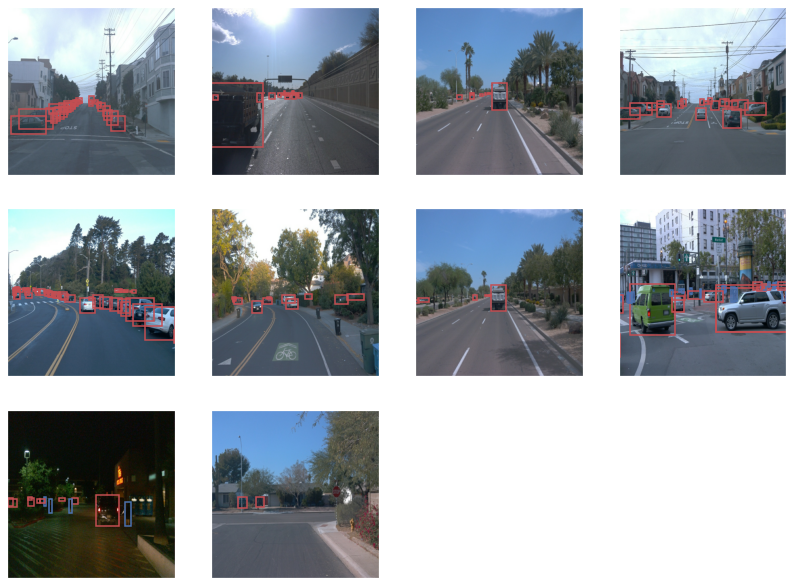

In [7]:
# Display 10 random images in dataset
display_images(batch_dataset, cols=4, row_size_grid=14, bbox_flag=True)

## Additional EDA

In this last part, you are free to perform any additional analysis of the dataset. What else would like to know about the data?
For example, think about data distribution. So far, you have only looked at a single file...

In [8]:
length_dataset = sum(1 for x in dataset)
length_dataset

1719

In [9]:
all_images = dataset.batch(1719).take(1)

In [10]:
import pandas as pd

def gen_tfrecord_df(data_dict):
    """Generate one image dataset from a dictionary.
    
    Args:
    -----
        data_dict: dict
            tfrecord dict 
    
    Returns:
    --------
        df: pandas.DataFrame
            Dataframe with columns "label", "xmin", "ymin", "ymax", "aspect_ratio"
            and "image_size_diagonal" containing info about bounding boxes.           
    """
    
    arr = gen_tfrecord_data(data_dict)[1]

    df = pd.DataFrame(arr, columns = ["label", "xmin", "xmax", "ymin", "ymax"])
    df["aspect_ratio"] = (df["xmax"]-df["xmin"])/(df["ymax"]-df["ymin"])
    df["image_size_diagonal"] = ((df["ymax"]-df["ymin"])**2 + (df["xmax"]-df["xmin"])**2)**0.5
    return df

In [11]:
for x in all_images:
    df_bboxes = gen_tfrecord_df(x)
grouped_df_bboxes = df_bboxes.groupby(["label"])

In [12]:
df_bboxes.shape

(38279, 7)

### Number of Images of each kind in the dataset

In [13]:
grouped_df_bboxes.count().rename({1: "vehicle", 2: "pedestrian", 4: "cyclist"})

,xmin,xmax,ymin,ymax,aspect_ratio,image_size_diagonal
label,,,,,,
vehicle,29710,29710,29710,29710,29710,29710
pedestrian,8355,8355,8355,8355,8355,8355
cyclist,214,214,214,214,214,214


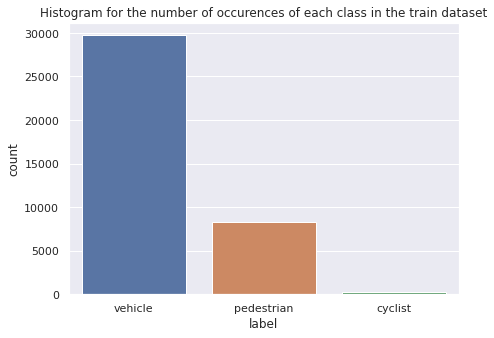

In [14]:
plt.figure(figsize=(7, 5))
sns.countplot(data = df_bboxes.replace({1: "vehicle", 2: "pedestrian", 4: "cyclist"}), x="label")
plt.title("Histogram for the number of occurences of each class in the train dataset")
plt.show()

### Info about bounding boxes with label 1: Vehicle

In [15]:
#Dataframe for only 'vehicle'
df_1 = grouped_df_bboxes.get_group(1)
df_1.describe()

,label,xmin,xmax,ymin,ymax,aspect_ratio,image_size_diagonal
count,29710.0,29710.000000,29710.000000,29710.000000,29710.000000,29710.000000,29710.000000
mean,1.0,273.028071,301.427271,324.636698,355.333938,1.027985,42.797646
std,0.0,136.143228,138.382183,29.060396,55.085015,0.541247,54.263886
min,1.0,0.000000,0.947385,45.474480,170.529312,0.044974,0.759073
25%,1.0,186.950653,214.164257,311.058052,327.163635,0.717947,13.237779
50%,1.0,283.162842,299.278915,324.795166,343.427063,0.887446,24.360045
75%,1.0,346.953430,367.164307,337.742767,365.216919,1.200009,48.064935
max,1.0,638.748047,640.000000,615.800232,640.000000,10.840475,681.399756


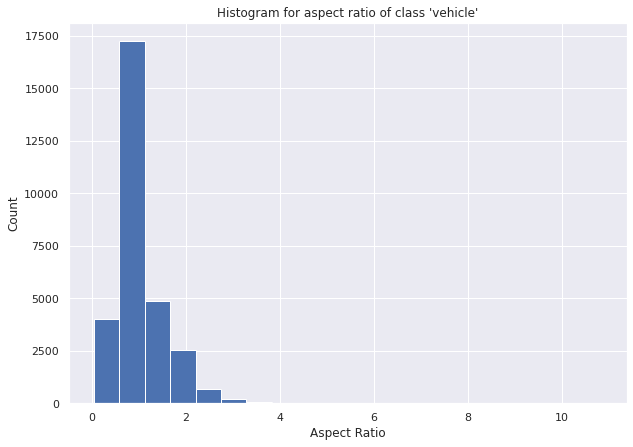

In [16]:
#Histogram for aspect ratios of bounding boxes of 'vehicle'
plt.figure(figsize=(10, 7))
plt.hist(df_1["aspect_ratio"], bins=20)
plt.ylabel("Count")
plt.xlabel("Aspect Ratio")
plt.title("Histogram for aspect ratio of class 'vehicle'")
plt.show()

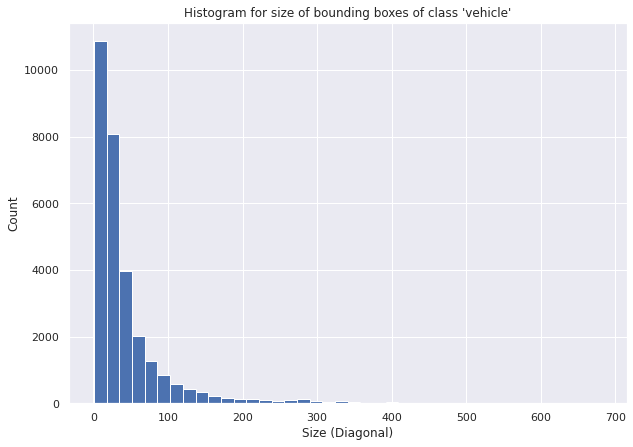

In [17]:
#Histogram for sizes (diagonal) of bounding boxes of 'vehicle'
plt.figure(figsize=(10, 7))
plt.hist(df_1["image_size_diagonal"], bins=40)
plt.ylabel("Count")
plt.xlabel("Size (Diagonal)")
plt.title("Histogram for size of bounding boxes of class 'vehicle'")
plt.show()

### Info about bounding boxes with label 2: Pedestrian

In [18]:
#Dataframe for only pedestrians
df_2 = grouped_df_bboxes.get_group(2)
df_2.describe()

,label,xmin,xmax,ymin,ymax,aspect_ratio,image_size_diagonal
count,8355.0,8355.000000,8355.000000,8355.000000,8355.000000,8355.000000,8355.000000
mean,2.0,314.560848,329.117560,322.389721,367.070781,0.349871,47.607250
std,0.0,173.312142,173.421746,25.796761,60.212561,0.213093,57.977427
min,2.0,0.000000,2.421095,0.000000,254.846573,0.055914,1.897700
25%,2.0,168.529266,185.161133,307.422516,331.584747,0.246558,18.267182
50%,2.0,327.058380,340.637543,320.058258,349.703522,0.297735,31.813023
75%,2.0,458.639587,471.797729,333.163727,382.908615,0.388889,57.126762
max,2.0,638.116394,640.000000,601.431580,640.000000,3.467382,905.096680


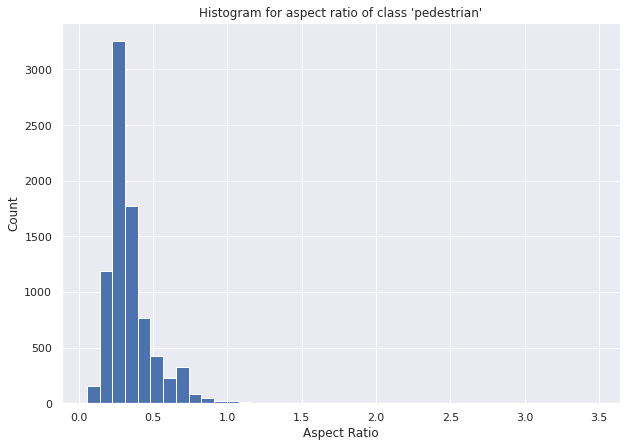

In [19]:
#Histogram for aspect ratios of bounding boxes of 'pedestrian'
plt.figure(figsize=(10, 7))
plt.hist(df_2["aspect_ratio"], bins=40)
plt.ylabel("Count")
plt.xlabel("Aspect Ratio")
plt.title("Histogram for aspect ratio of class 'pedestrian'")
plt.show()

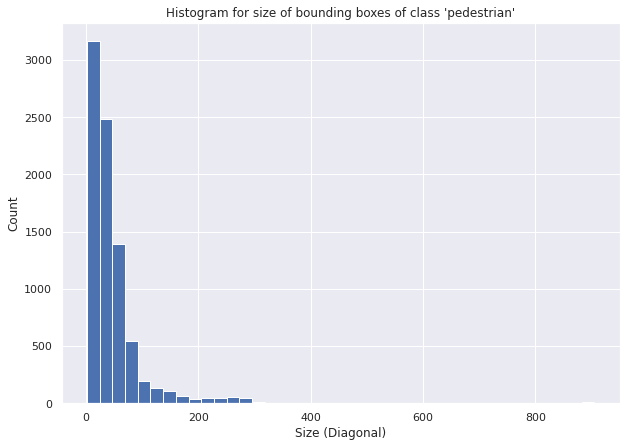

In [20]:
#Histogram for sizes (diagonal) of bounding boxes of 'pedestrian'
plt.figure(figsize=(10, 7))
plt.hist(df_2["image_size_diagonal"], bins=40)
plt.ylabel("Count")
plt.xlabel("Size (Diagonal)")
plt.title("Histogram for size of bounding boxes of class 'pedestrian'")
plt.show()

### Info about bounding boxes with label 4: Cyclists

In [21]:
#Dataframe for only cyclists
df_4 = grouped_df_bboxes.get_group(4)
df_4.describe()

,label,xmin,xmax,ymin,ymax,aspect_ratio,image_size_diagonal
count,214.0,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,4.0,287.822125,302.049995,325.909067,359.469791,0.427224,36.812603
std,0.0,167.920331,170.205645,26.742173,48.762683,0.166351,38.047677
min,4.0,0.000000,10.315970,276.320618,290.491394,0.164609,1.897692
25%,4.0,158.371193,168.266098,304.426346,324.479370,0.294054,16.045932
50%,4.0,288.026077,291.089310,324.795166,351.321930,0.381903,25.127769
75%,4.0,403.059891,420.013504,344.848122,376.348686,0.526615,39.841485
max,4.0,633.169006,640.000000,447.165710,640.000000,0.897961,289.786692


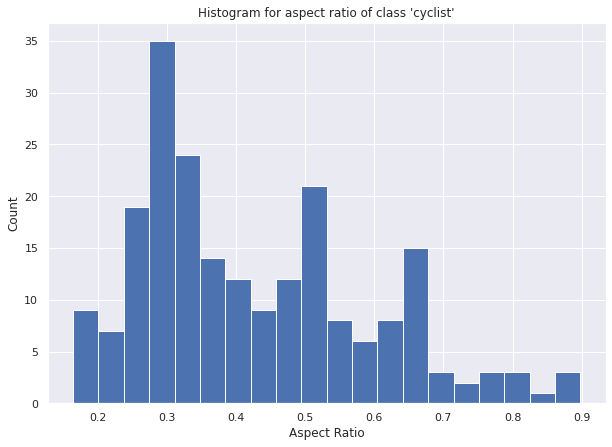

In [22]:
#Histogram for aspect ratios of bounding boxes of 'cyclist'
plt.figure(figsize=(10, 7))
plt.hist(df_4["aspect_ratio"], bins=20)
plt.ylabel("Count")
plt.xlabel("Aspect Ratio")
plt.title("Histogram for aspect ratio of class 'cyclist'")
plt.show()

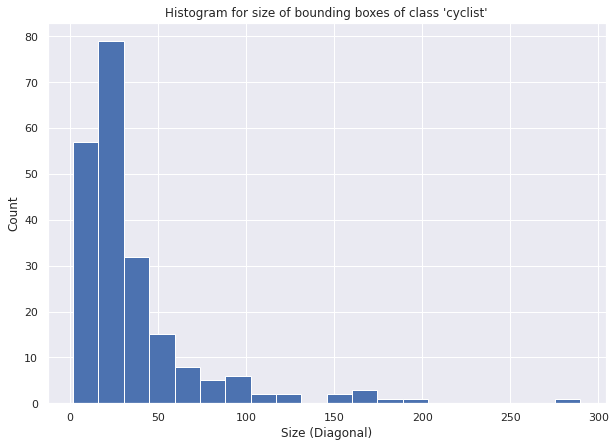

In [23]:
#Histogram for sizes (diagonal) of bounding boxes of 'cyclist'
plt.figure(figsize=(10, 7))
plt.hist(df_4["image_size_diagonal"], bins=20)
plt.ylabel("Count")
plt.xlabel("Size (Diagonal)")
plt.title("Histogram for size of bounding boxes of class 'cyclist'")
plt.show()